**DonorsChoose**

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>


## About the DonorsChoose Data Set

The train.csv data set provided by DonorsChoose contains the following features:
*    project_id	- A unique identifier for the proposed project

*    project_title -	Title of the project

*    project_grade_category	- Grade level of students for which the project is targeted.

*    project_subject_categories -	One or more (comma-separated) subject categories

*    school_state -	State where school is located (Two-letter U.S. postal code).

*    project_subject_subcategories -	One or more (comma-separated) subject subcategories for the project.

*    project_resource_summary	-An explanation of the resources needed for the project

*    project_submitted_datetime	-Datetime when project application was submitted. E

*    teacher_id	-A unique identifier for the teacher of the proposed project.

*    teacher_prefix	- Teacher's title

*   teacher_number_of_previously_posted_projects -	Number of project applications previously submitted by the same teacher.

*    project_resource_summary

*    project_essay_1	-First application essay*

*    project_essay_2	-Second application essay*

*    project_essay_3	-Third application essay*

*    project_essay_4	-Fourth application essay*

*    project_essay_1:"Introduce us to your classroom"



Additionally, the **resources.csv** data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project


*   List item id-	A project_id value from the train.csv file. Example: p036502

*   List item description	-Desciption of the resource. Example: Tenor Saxophone Reeds, Box of 25

*   List item quantity-	Quantity of the resource required. Example: 3

*   List item price	-Price of the resource required. Example: 9.95


In [1]:
 %matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')

Output hidden; open in https://colab.research.google.com to view.

## 1.1 Reading Data

In [14]:
#reading dataset
os.chdir("/content/drive/MyDrive/2024/NLP/LSTM/data")
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [15]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)
print('-'*50)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']
--------------------------------------------------


In [16]:
print("Number of data points in train data", resource_data.shape)
print('-'*50)
print(resource_data.columns.values)
print('-'*50)
resource_data.head(2)

Number of data points in train data (1541272, 4)
--------------------------------------------------
['id' 'description' 'quantity' 'price']
--------------------------------------------------


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


# 1.2 Data Analysis

Number of projects are approved for funding  92706 - 84.85830404217927 %
Number of projects are not approved for funding  16542 - 15.141695957820739 %


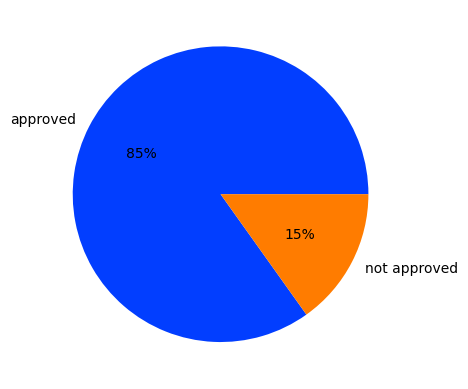

In [17]:
y_value_counts = project_data['project_is_approved'].value_counts()

print("Number of projects are approved for funding ",
      y_value_counts[1], "-", (y_value_counts[1]/(project_data.shape[0]))*100,"%")
print("Number of projects are not approved for funding ",
      y_value_counts[0], "-", (y_value_counts[0]/(project_data.shape[0]))*100,"%")

data = [(y_value_counts[1]/(project_data.shape[0]))*100
        , (y_value_counts[0]/(project_data.shape[0]))*100]
keys = ['approved', 'not approved']

palette_color = sns.color_palette('bright')
plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
plt.show()


### 1.2.1 Univariate Analysis: School State

In [18]:
# https://datascience.stackexchange.com/questions/9616/how-to-create-us-state-choropleth-map/9620#9620

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
temp.columns = ['state_code', 'num_proposals']

# Set color scale
scl = [[0.0, 'rgb(242,240,247)'], [0.2, 'rgb(218,218,235)'], [0.4, 'rgb(188,189,220)'], \
       [0.6, 'rgb(158,154,200)'], [0.8, 'rgb(117,107,177)'], [1.0, 'rgb(84,39,143)']]

data = [dict(
    type='choropleth',
    colorscale=scl,
    autocolorscale=False,
    locations=temp['state_code'],
    z=temp['num_proposals'].astype(float),
    locationmode='USA-states',
    text=temp['state_code'],
    marker=dict(line=dict(color='rgb(255,255,255)', width=2)),
    colorbar=dict(title="% of proposals accepted")
)]

layout = dict(
    title='Project Proposals % of Acceptance Rate by US States',
    geo=dict(
        scope='usa',
        projection=dict(type='albers usa'),
        showlakes=True,
        lakecolor='rgb(255, 255, 255)',
    ),
)

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')
offline.plot(fig, filename='us-map-heat-map.html', auto_open=True)

#saved in loc

'us-map-heat-map.html'

In [19]:
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))
print('='*50)
print("States with highest % approvals")
print(temp.tail(5))

States with lowest % approvals
   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245
States with highest % approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


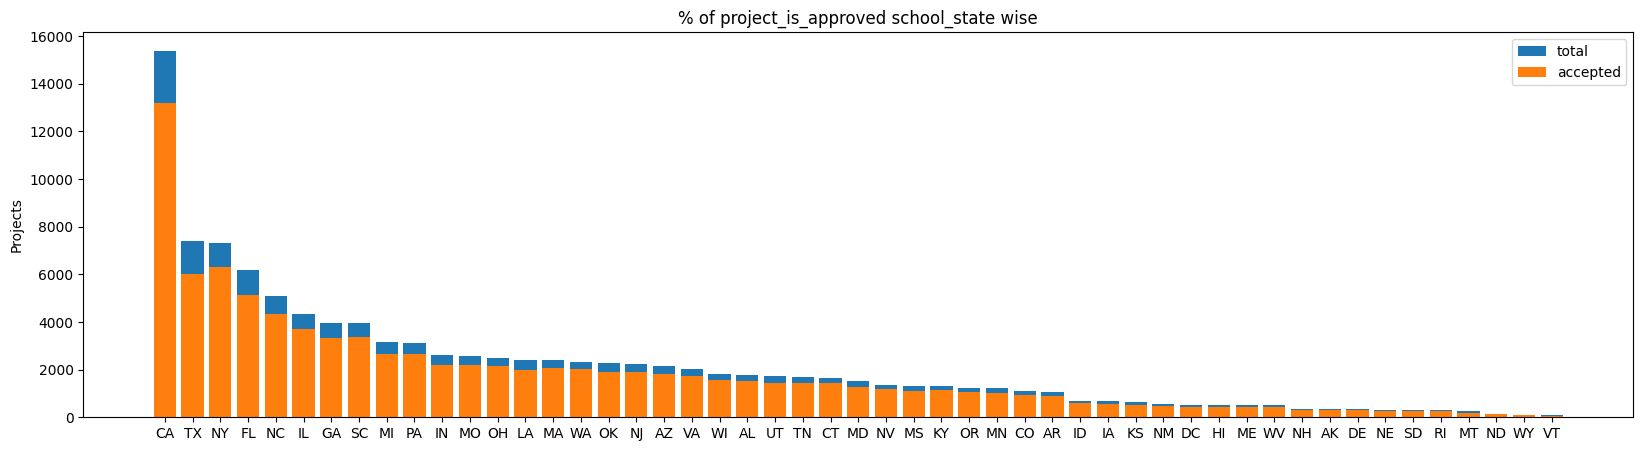

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [20]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])

    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title(f'% of project_is_approved {xtick} wise')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

def univariate_barplots(data, col1, col2='project_is_approved', top=False):

    temp = pd.DataFrame(data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    temp['total'] = pd.DataFrame(data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']

    temp.sort_values(by=['total'], inplace=True, ascending=False)

    if top:
        temp = temp.head(top)

    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("=" * 50)
    print(temp.tail(5))

univariate_barplots(project_data, 'school_state', 'project_is_approved', False)

>Every state is having more than 80% success rate in approval

### 1.2.2 Univariate Analysis: teacher_prefix

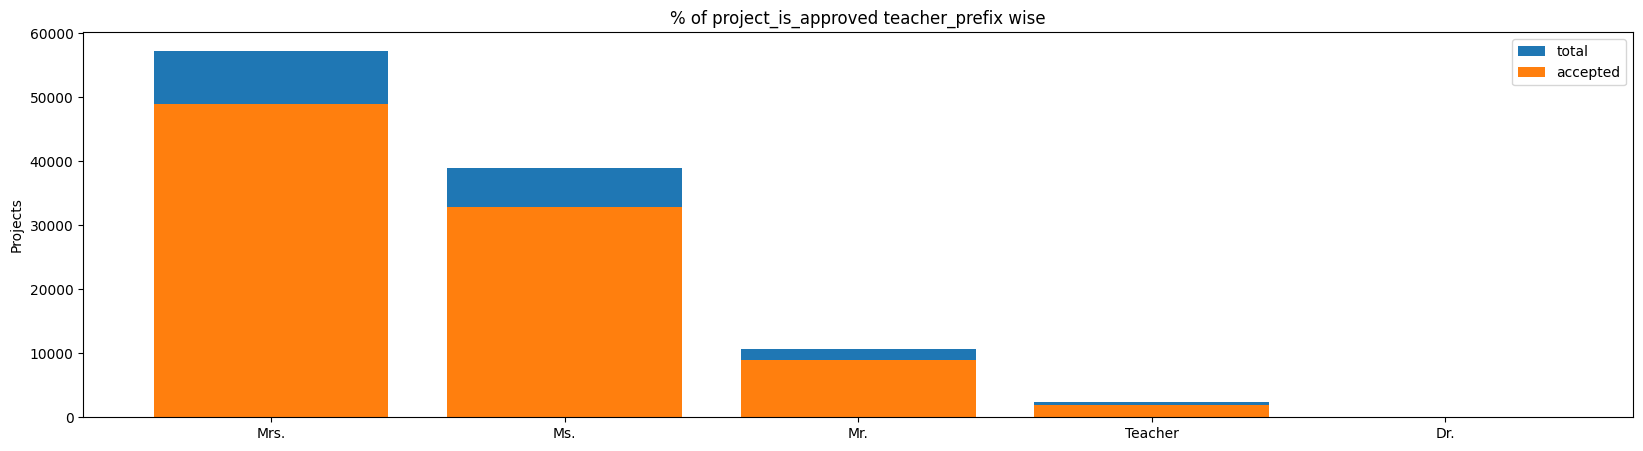

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [21]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)

>Projects led by teachers with the titles 'Mrs.' and 'Ms.' exhibit higher approval rates, while those with 'Dr.' have a comparatively lower approval rate.
>This data highlights potential correlations between teacher prefixes






### 1.2.3 Univariate Analysis: project_grade_category

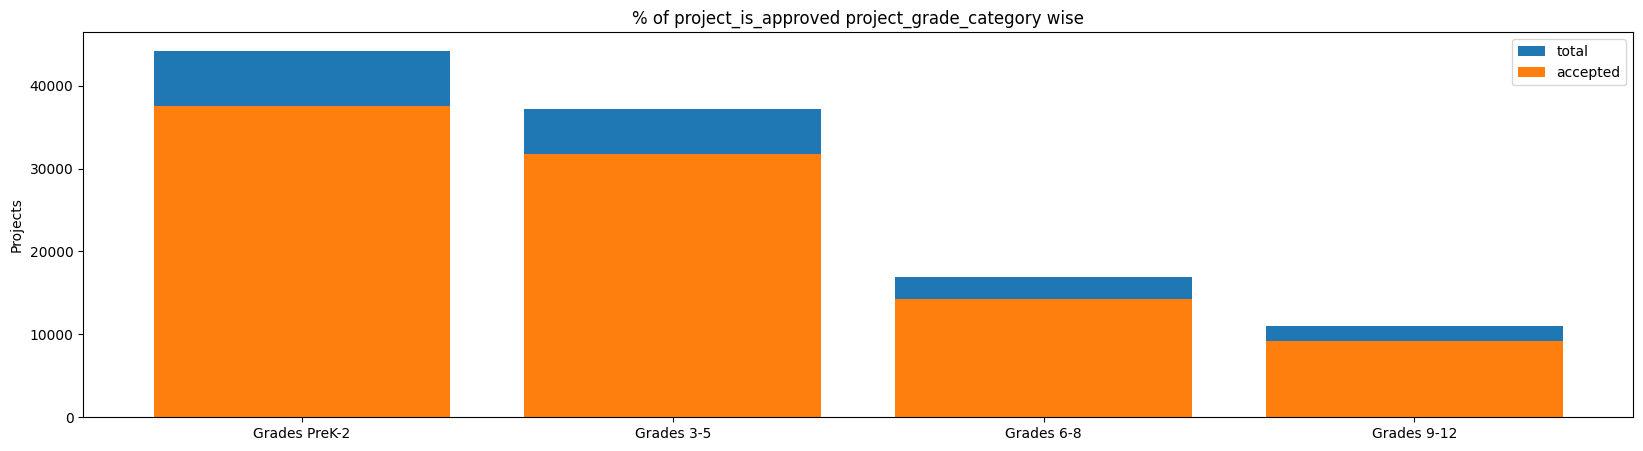

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [22]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', top=False)

>Every project grade is having more than 83% approval rate in approval

### 1.2.4 Univariate Analysis: project_subject_categories

In [23]:
def cleanCategories(projectCategories):
  clean_projectCategories = []
  for category in projectCategories:
    temp = ""
    for i in category.split(","):
      i = i.strip() #will remove the trailing spaces
      i = i.replace(" " , "")
      i = i.replace("&" , "_")
      i = i.replace("," , " ")
      i = i.replace("The" , "")
      temp+=i+" "
    temp = temp.strip()
    clean_projectCategories.append(temp)
  return clean_projectCategories

projectCategories =list(project_data['project_subject_categories'].values)
print(projectCategories[0:5])
clean_projectCategories = cleanCategories(projectCategories)
print("-"*50)
print("-"*50)
print(clean_projectCategories[0:5])

['Literacy & Language', 'History & Civics, Health & Sports', 'Health & Sports', 'Literacy & Language, Math & Science', 'Math & Science']
--------------------------------------------------
--------------------------------------------------
['Literacy_Language', 'History_Civics Health_Sports', 'Health_Sports', 'Literacy_Language Math_Science', 'Math_Science']


In [24]:
project_data['clean_categories'] =clean_projectCategories
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language


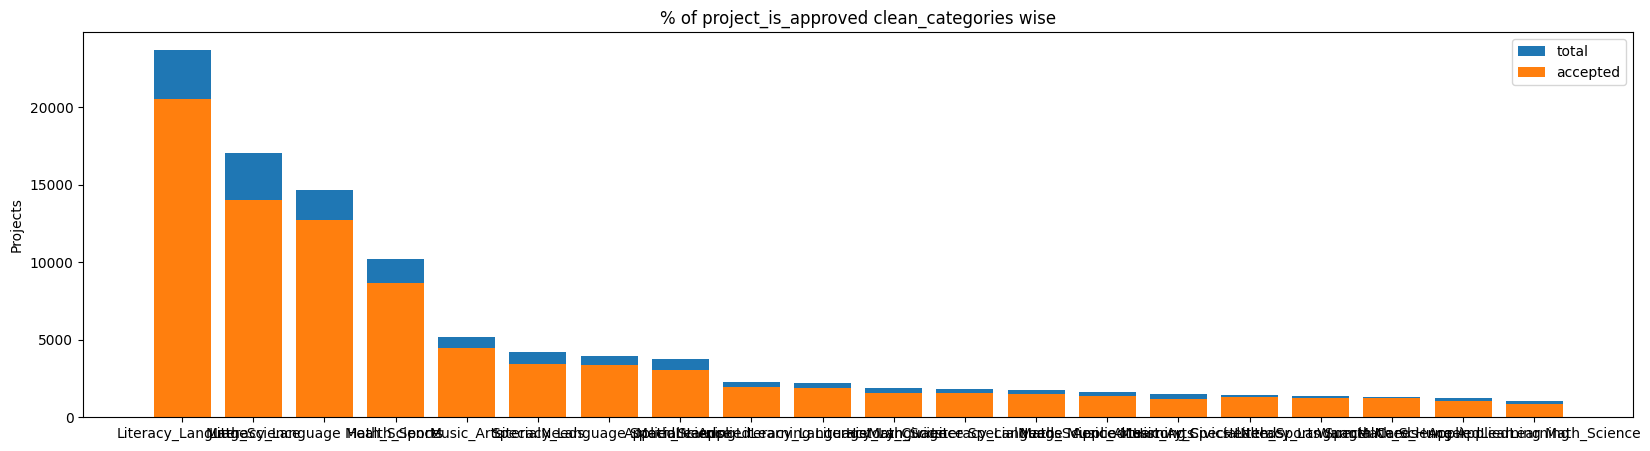

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [25]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)

>High approval rates observed for 'Literacy_Language' and 'History_CivicsLiteracy_Language' categories.




>Slightly lower approval rates seen in 'Math_Science AppliedLearning' and 'AppliedLearning Math_Science' categories.

In [26]:
# count of all the words in clean_categories
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)

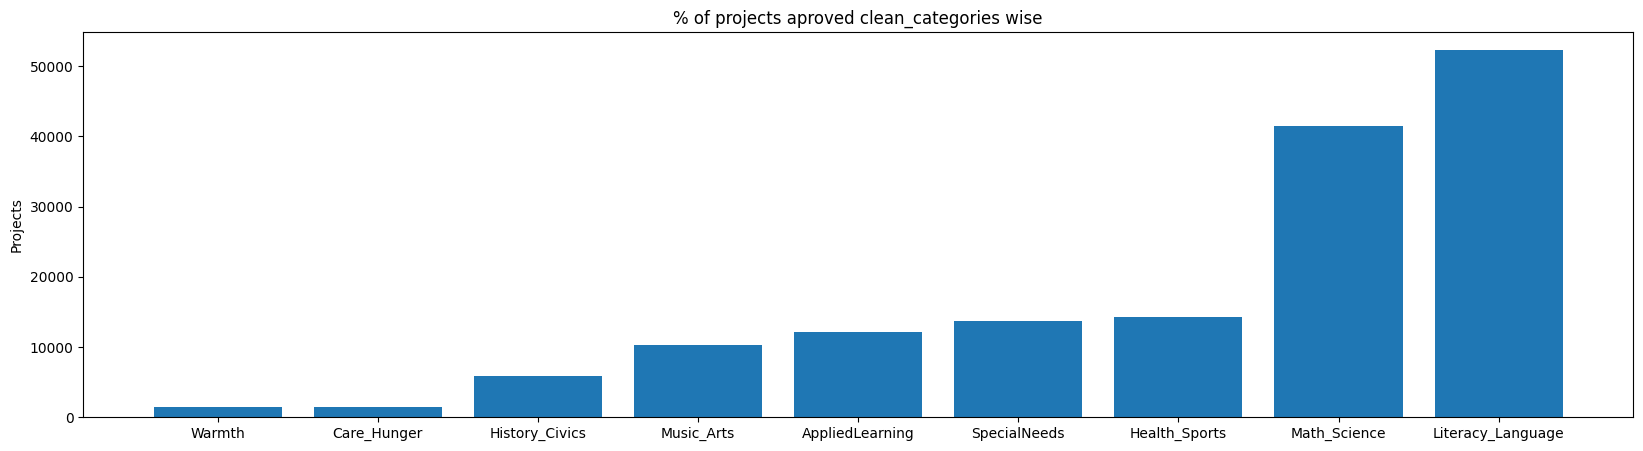

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


In [27]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved clean_categories wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

print("=="*50)
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

>clean categories -Math_Science-41421 ,Literacy_Language-52239 have highest approval rate

### 1.2.5 Univariate Analysis: project_subject_subcategories

In [28]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
clean_projectCategories = cleanCategories(sub_catogories)
print( "number of unique subcategories :", len(set(clean_projectCategories)))

number of unique subcategories : 401


In [60]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
clean_projectCategories = cleanCategories(sub_catogories)
print("unique clean sub category :" ,len(set(clean_projectCategories)))
print("--"*50)
project_data['clean_subcategories'] = clean_projectCategories
# project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

unique clean sub category : 401
----------------------------------------------------------------------------------------------------


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,...,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,...,NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,My students are English learners that are work...,154.6,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,Our students arrive to our school eager to lea...,299.0,1


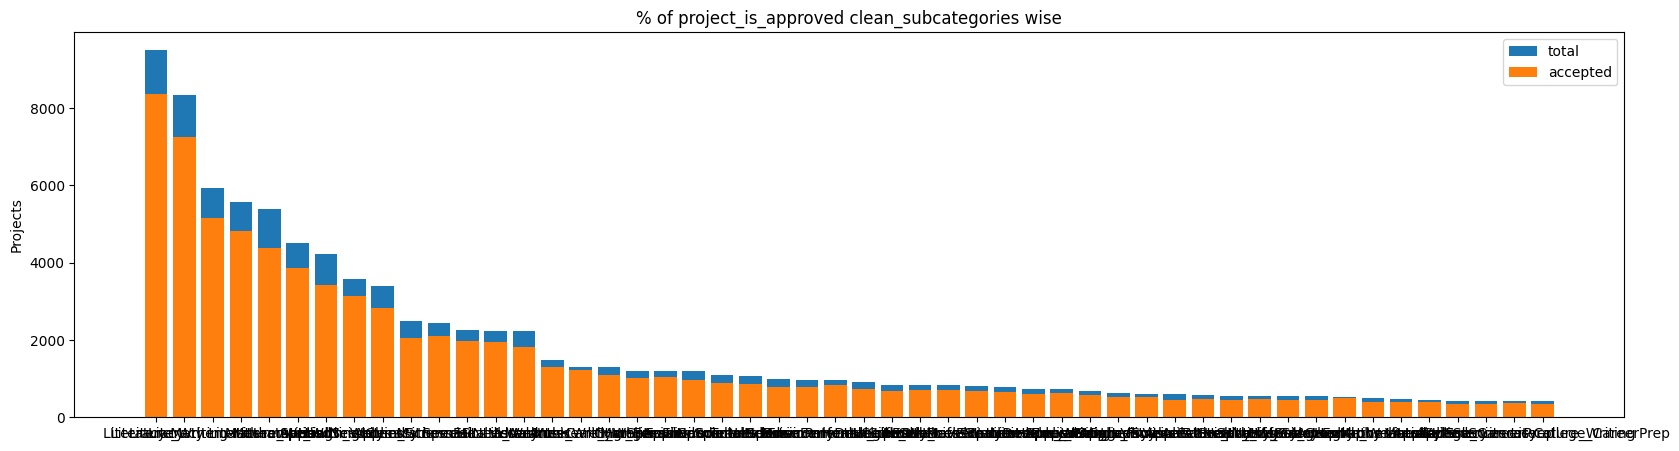

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [30]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)

In [31]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

sub_cat_dict = dict(my_counter)

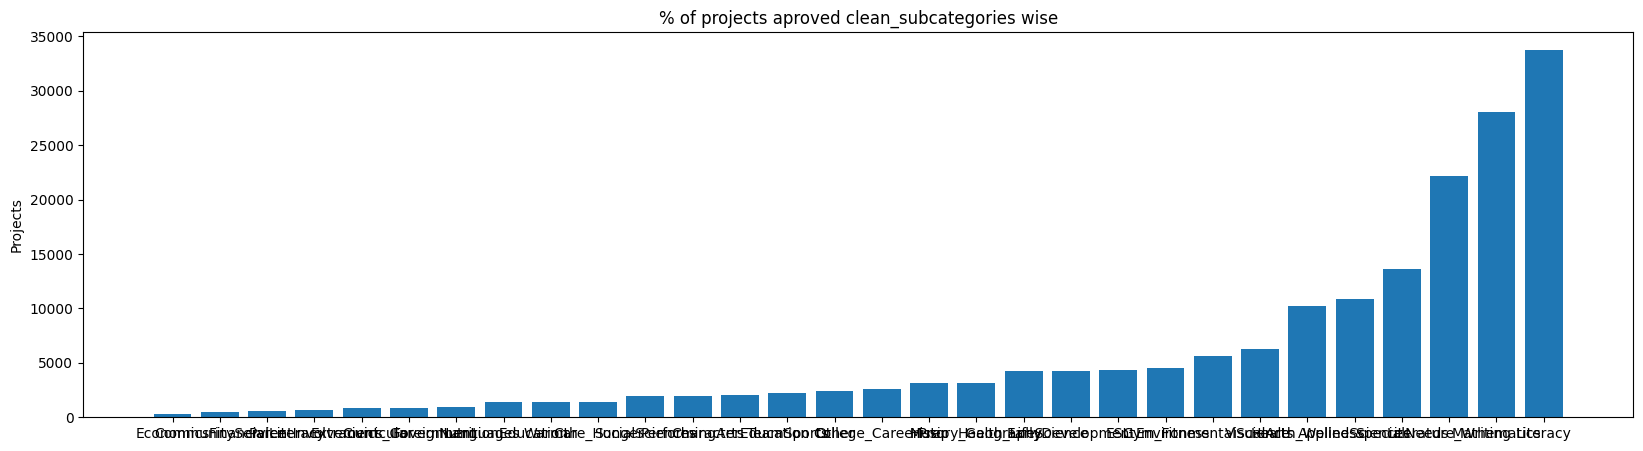

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


In [32]:
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved clean_subcategories wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

print("=="*50)
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

### 1.2.6 Univariate Analysis: Text features (Title)

In [33]:
project_data['project_title'][0:5]

0     Educational Support for English Learners at Home
1                Wanted: Projector for Hungry Learners
2    Soccer Equipment for AWESOME Middle School Stu...
3                               Techie Kindergarteners
4                               Interactive Math Tools
Name: project_title, dtype: object

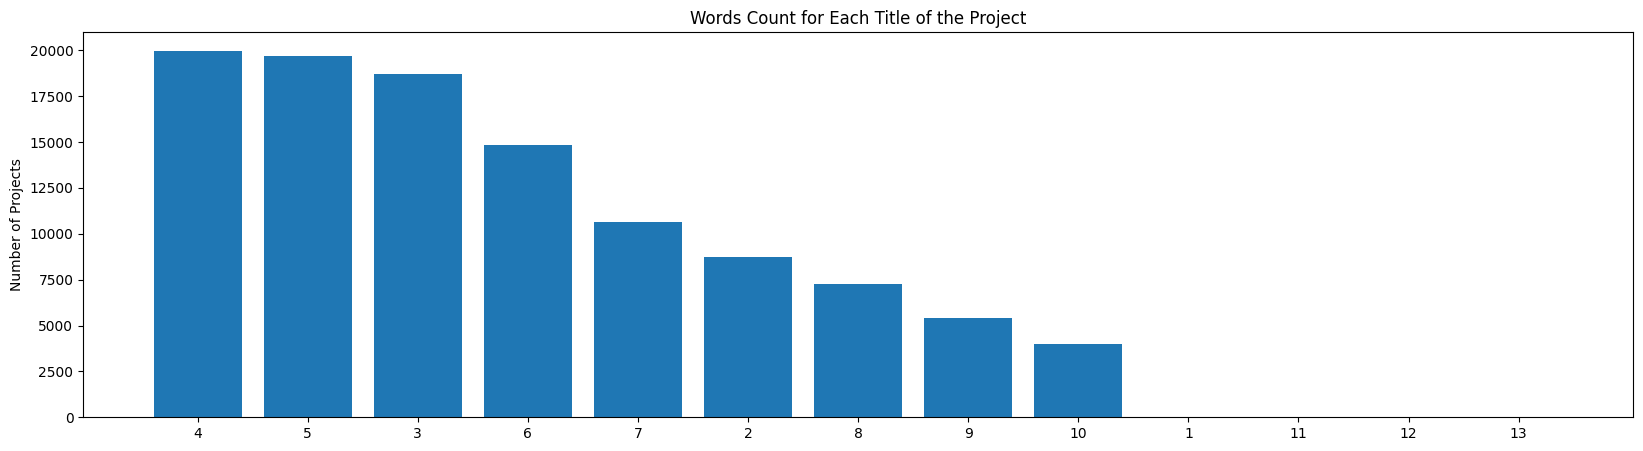

In [63]:
#counting words in Project Title

#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1], reverse=True))  # Sort in descending order

ind = np.arange(len(word_dict))
plt.figure(figsize=(20, 5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of Projects')
plt.title('Words Count for Each Title of the Project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()


>most of project title word count is in between 2 to 10

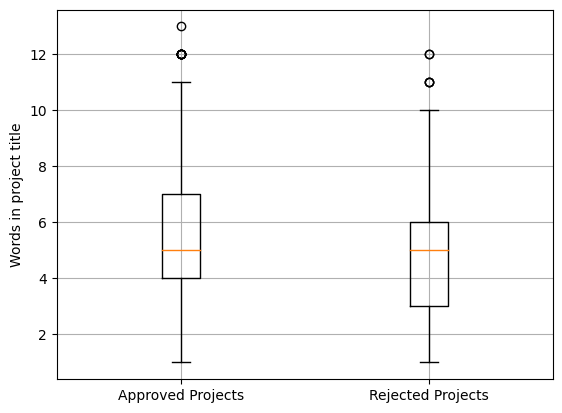

In [35]:
approved_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

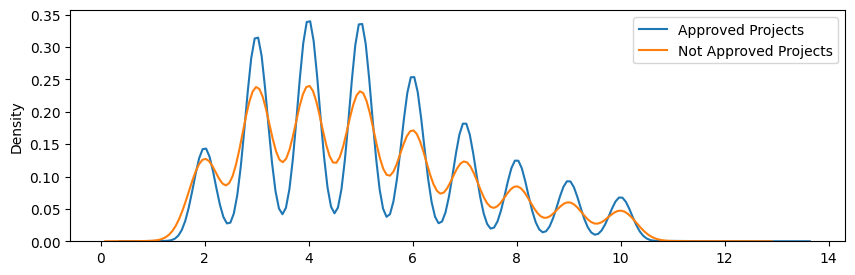

In [36]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.legend()
plt.show()

### 1.2.7 Univariate Analysis: Text features (Project Essay's)

In [37]:
# merge two column text dataframe:
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [38]:
print(project_data["project_essay_1"][0])
print("="*50)
print(project_data["essay"][0])

My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.
My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and ex

In [39]:
word_count = project_data['essay'].str.split().apply(len).value_counts()
word_dict = dict(word_count)

In [40]:
print(word_dict)

{189: 1257, 191: 1208, 188: 1204, 186: 1186, 192: 1172, 190: 1157, 196: 1151, 195: 1148, 187: 1145, 193: 1140, 194: 1117, 198: 1109, 185: 1108, 184: 1097, 197: 1094, 199: 1020, 183: 1020, 182: 1018, 202: 1008, 203: 1007, 181: 985, 200: 985, 206: 980, 204: 965, 201: 952, 210: 924, 205: 923, 209: 921, 208: 916, 211: 909, 212: 904, 207: 902, 214: 899, 180: 851, 216: 849, 213: 837, 218: 833, 215: 829, 217: 821, 220: 806, 221: 802, 222: 784, 223: 783, 224: 766, 225: 765, 219: 763, 179: 743, 227: 728, 226: 726, 228: 725, 231: 707, 229: 697, 243: 685, 234: 680, 230: 675, 236: 674, 235: 661, 238: 659, 237: 654, 240: 652, 232: 648, 233: 645, 244: 616, 242: 613, 248: 612, 241: 607, 245: 603, 239: 602, 246: 583, 253: 583, 247: 571, 249: 566, 251: 560, 252: 556, 250: 550, 254: 548, 256: 533, 257: 532, 255: 525, 268: 521, 258: 520, 260: 515, 259: 513, 261: 511, 263: 509, 264: 487, 275: 476, 276: 474, 266: 471, 267: 471, 270: 467, 262: 463, 265: 461, 273: 458, 272: 455, 269: 447, 280: 440, 294: 435,

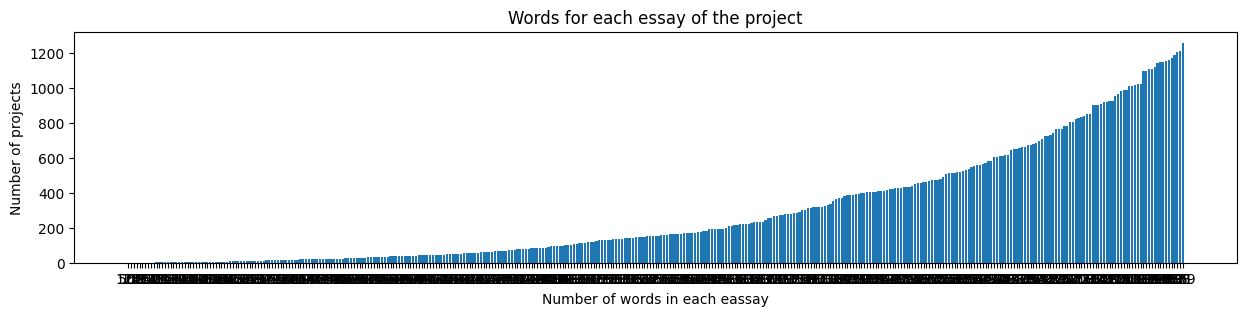

In [41]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['essay'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(15,3))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of projects')
plt.xlabel('Number of words in each eassay')
plt.title('Words for each essay of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

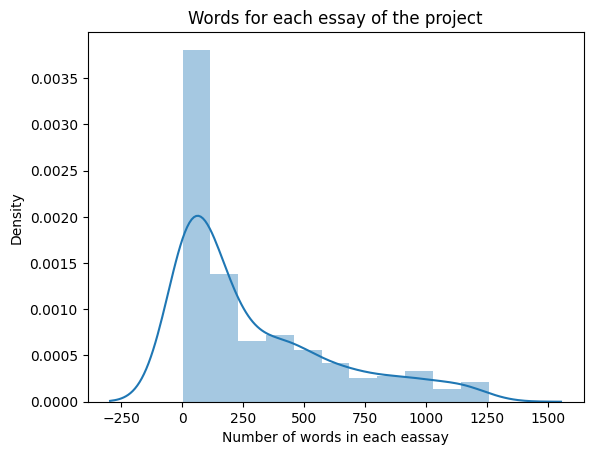

In [42]:
sns.distplot(word_count.values)
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.show()

> number of words in essay in between 0 to 1250

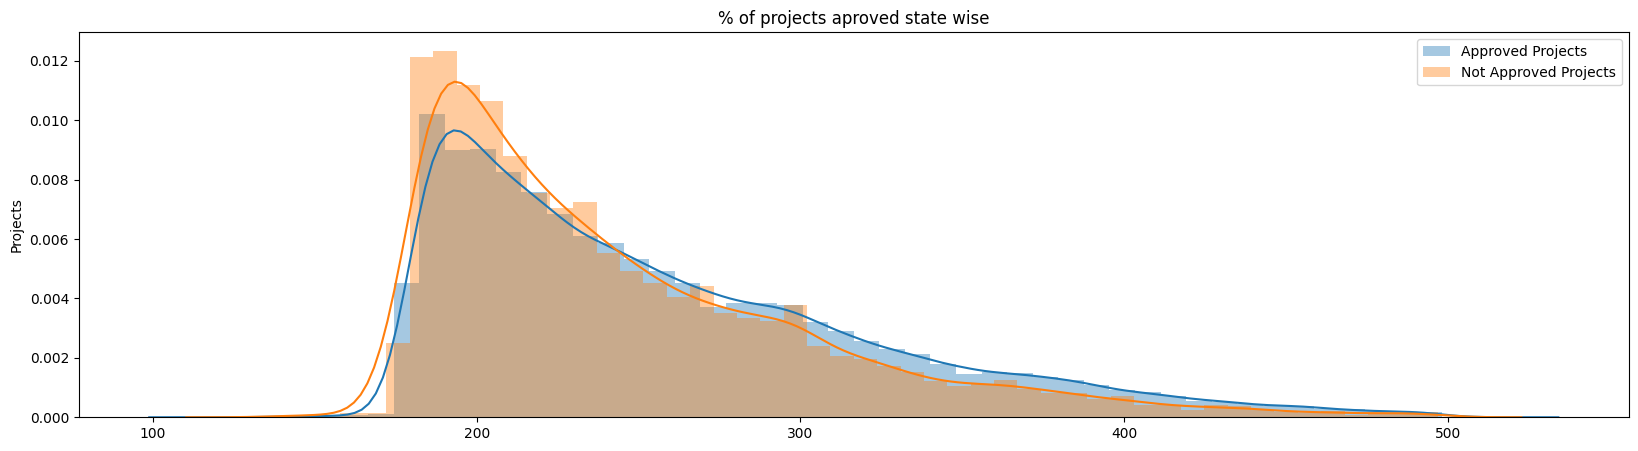

In [43]:
approved_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

plt.figure(figsize=(20,5))
p1 = sns.distplot(approved_word_count , label="Approved Projects")
p2 = sns.distplot(rejected_word_count ,label="Not Approved Projects")

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
# plt.xticks(ind, list(data[xtick].values))
# plt.legend((p1[0], p2[0]), ('total', 'accepted'))
plt.legend()
plt.show()

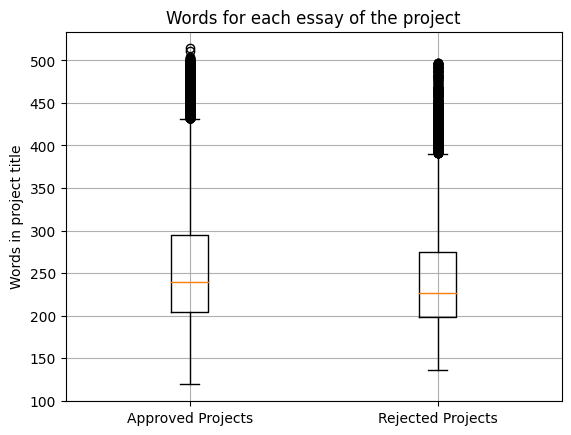

In [44]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

### 1.2.8 Univariate Analysis: Cost per project

In [45]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [46]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [47]:
# join two dataframes in python:
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [48]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

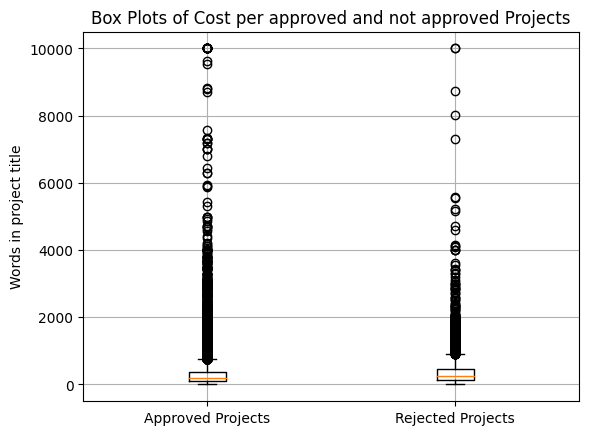

In [49]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

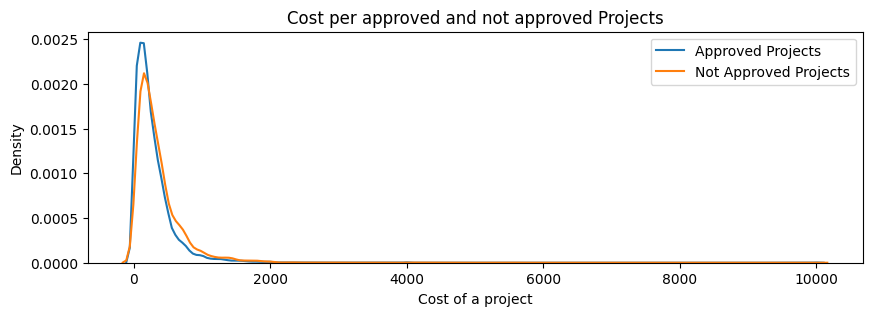

In [50]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

In [51]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

>approved project between 25th to 90 is 99-593

>rejected project price between 25th to 75th percentile is 140-739

>rejected prject have higher price compare to accepted price

<h3><font>1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects</font></h3>

In [52]:
teacher_number_of_previously_posted =project_data["teacher_number_of_previously_posted_projects"].values

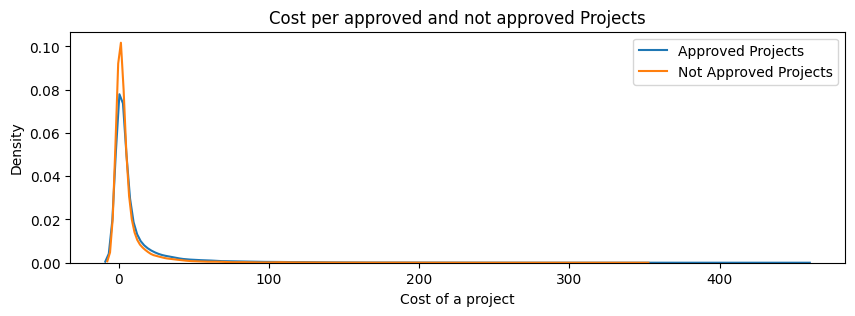

In [53]:
approved_teacher_number_of_previously_posted_projects = project_data[project_data['project_is_approved']==1]['teacher_number_of_previously_posted_projects'].values

rejected__teacher_number_of_previously_posted_projects = project_data[project_data['project_is_approved']==0]['teacher_number_of_previously_posted_projects'].values

plt.figure(figsize=(10,3))
sns.distplot(approved_teacher_number_of_previously_posted_projects, hist=False, label="Approved Projects")
sns.distplot(rejected__teacher_number_of_previously_posted_projects, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

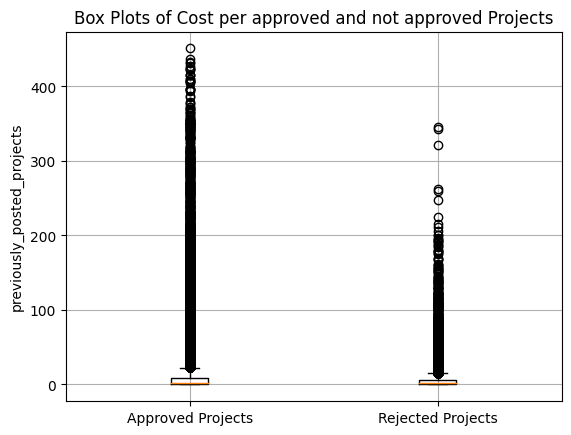

In [54]:
plt.boxplot([approved_teacher_number_of_previously_posted_projects, rejected__teacher_number_of_previously_posted_projects])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('previously_posted_projects')
plt.grid()
plt.show()

In [55]:
x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_teacher_number_of_previously_posted_projects,i), 3),
               np.round(np.percentile(rejected__teacher_number_of_previously_posted_projects,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.0        |          0.0          |
|     5      |        0.0        |          0.0          |
|     10     |        0.0        |          0.0          |
|     15     |        0.0        |          0.0          |
|     20     |        0.0        |          0.0          |
|     25     |        0.0        |          0.0          |
|     30     |        1.0        |          0.0          |
|     35     |        1.0        |          1.0          |
|     40     |        1.0        |          1.0          |
|     45     |        2.0        |          1.0          |
|     50     |        2.0        |          2.0          |
|     55     |        3.0        |          2.0          |
|     60     |        4.0        |          3.0          |
|     65     |        5.0        |          3.0         